# Modeling

**University of San Diego, M.S. Applied Data Science**

Lai Leng Chan, Minsu Kim, Christopher Garcia

This notebook contains predictive  models, model validation as well as model evalaution. 

In [4]:
#pip install imblearn

In [1]:
# Import required libraries and packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import xgboost

# Preprocessing Packages
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler

# Modeling packages
from sklearn.metrics import log_loss 
from sklearn.metrics import precision_recall_curve, average_precision_score 
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report 

# Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

# Set seed for reproducibility
import random
random.seed(101)

In [2]:
def scale_features(X, scaling_method='minmax'):
    """
    Scale the features in X using Standardization.

    Parameters:
        X (DataFrame): The features DataFrame to be scaled.
        scaling_method (str): The scaling used is Standardization

    Returns:
        DataFrame: The scaled features DataFrame.
    """

    if scaling_method not in ['standard']:
        raise ValueError("Invalid scaling_method. Options 'standard'.")
    else:
        scaler = StandardScaler()

    # Fit and transform the features using the chosen scaler
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    return X_scaled

### Read Data

In [3]:
df = pd.read_csv('/Users/annie/Documents/GitHub/MSADS-Capstone-CryptoCurrencyFraudDetection/Data/new_data_file.csv')
df.head()

,Unnamed: 0,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,...,max val sent,avg val sent,min value sent to contract,max val sent to contract,avg value sent to contract,total transactions (including tnx to create contract,total Ether sent,total ether received,total ether sent contracts,total ether balance
0,0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,...,31.220000,1.200681,0.0,0.0,0.0,810,865.691093,586.466675,0.0,-279.224419
1,1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,...,1.800000,0.032844,0.0,0.0,0.0,102,3.087297,3.085478,0.0,-0.001819
2,2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,...,3.538616,1.794308,0.0,0.0,0.0,12,3.588616,3.589057,0.0,0.000441
3,3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,...,450.000000,70.001834,0.0,0.0,0.0,34,1750.045862,895.399559,0.0,-854.646303
4,4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,...,9.000000,0.022688,0.0,0.0,0.0,4619,104.318883,53.421897,0.0,-50.896986


## Train-Test Split

The data is split into <number> trianing set, <> for a validation set as well as <number> for a testing set. This ensures we have enough data set to test our models since we do not have a large number of observations. The data sets are then saved into separete csv files in order to prepare for modeling.

In [4]:
# Create training and testing datasets
# Save to data folder for modeling
# Set random number for reproducibiltiy
random_state = 111

# Features to be used for model
features = df[['total ether received', 'avg val received', 'Unique Received From Addresses', 'Time Diff between first and last (Mins)', 
               'Received Tnx', 'total transactions (including tnx to create contract', 'Avg min between received tnx', 'Sent tnx',
               'total ether balance', 'Avg min between sent tnx']]
target_feature = df['FLAG']

In [5]:
# Split the data into training (80%) and temporary rest (20%)
X_train_temp, X_test, y_train_temp, y_test = train_test_split(features, target_feature, 
                                                              test_size=0.2, 
                                                              random_state=42,
                                                              stratify=target_feature)

# Split the temporary rest into validation (50%) and testing (50%)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, 
                                                  test_size=0.5, 
                                                  random_state=42)

In [6]:
# Check shape of data
print('Training Size:', len(X_train))
print('Validation Size:', len(X_val))
print('Testing Size', len(X_test))

Training Size: 3936
Validation Size: 3936
Testing Size 1969


In [7]:
# Fit and apply the oversampling technique to training data to correct class imbalance
oversampler = RandomOverSampler(random_state=random_state)
X_train_oversampled, y_train = oversampler.fit_resample(X_train_temp, y_train_temp)

In [8]:
# Check the balanced class distribution after oversampling
print("Class distribution after oversampling:", pd.Series(y_train).value_counts())

Class distribution after oversampling: FLAG
0    6129
1    6129
Name: count, dtype: int64


In [9]:
# Save new features to 
X_scaled_train = scale_features(X_train_oversampled, scaling_method='standard')
X_scaled_val = scale_features(X_val, scaling_method='standard')
X_scaled_test = scale_features(X_test, scaling_method='standard')

In [10]:
# Check shape of data
print('Training Size:', len(X_scaled_train))
print('Validation Size:', len(X_scaled_val))
print('Testing Size', len(X_scaled_test))

Training Size: 12258
Validation Size: 3936
Testing Size 1969


## Models

### Logistic Regression (Baseline Model)

Logistic Regression is a binary classification algorithm that models the relationship between the input features and the binary outcome using a logistic function. It predicts the probability of the binary outcome, which can then be thresholded to make binary predictions. It serves as the baseline model to establish a minimum level of performance for fraud detection. By using Logistic Regression as a starting point, we can gauge the performance of more complex models and assess whether their added complexity leads to significantly improved results in identifying fraudulent transactions.

In [25]:
# Build the logistic regression model
logistic_model = LogisticRegression(random_state=random_state)

# Fit the model to the training data
logistic_model.fit(X_scaled_train, y_train)

# Predictions on the validation data
y_val_pred = logistic_model.predict(X_scaled_val)

# Model evaluation with validation data
classification_report_lr = classification_report(y_val, y_val_pred)
print('Classification Report:\n', classification_report_lr)

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.45      0.61      3105
           1       0.30      0.90      0.45       831

    accuracy                           0.54      3936
   macro avg       0.62      0.67      0.53      3936
weighted avg       0.81      0.54      0.58      3936



### Random Forest

Random Forest is an ensemble learning method based on decision trees, where multiple trees are built using different subsets of the data and features. It combines their predictions to improve accuracy and reduce overfitting. It is effective in handling complex datasets, provides feature importance insights, and is robust against outliers and irrelevant features, making it well-suited for fraud detection tasks where accurate classification and interpretability are crucial.

During Grid Search, param_grid will systematically try all possible combinations of the specified hyperparameters using cross-validation. It evaluates each combination's performance on the validation set and selects the hyperparameter values that result in the best model performance, typically based on a chosen evaluation metric such as accuracy or F1-score. This process helps find the optimal hyperparameters that yield the highest model performance for the given task.

In [12]:
# Building the initial Random Forest classifier
random_forest_model = RandomForestClassifier(random_state=random_state)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [None, 10, 20],     # Maximum depth of the tree
    'min_samples_split': [2, 5, 10], # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],   # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider when looking for the best split
}

# Initialize GridSearchCV to perform hyperparameter tuning
grid_search = GridSearchCV(estimator=random_forest_model, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_scaled_train, y_train)

# Get the best hyperparameters found by GridSearchCV
best_params = grid_search.best_params_
print('Best Hyperparameters:', best_params)

Best Hyperparameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [26]:
# Train the model with the best hyperparameters
best_random_forest_model = RandomForestClassifier(random_state=random_state, **best_params)
best_random_forest_model.fit(X_scaled_train, y_train)

# Make predictions on the validation data
y_val_pred = best_random_forest_model.predict(X_scaled_val)

# Model evaluation with validation data
classification_report_rf = classification_report(y_val, y_val_pred)
print('Classification Report:\n', classification_report_rf)

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.82      0.85      3105
           1       0.46      0.58      0.52       831

    accuracy                           0.77      3936
   macro avg       0.67      0.70      0.68      3936
weighted avg       0.79      0.77      0.78      3936



### XG Boost

In [14]:
# XGBoost Model
xgb = XGBClassifier(random_state=random_state)

# Hyperparameter tuning
param_grid_xgb = {
        'min_child_weight': [1, 5, 10], #minimum sum of weights of all observations required in a child
        'gamma': [0.5, 1, 1.5, 2, 5], #minimum loss reduction required to make a split
        'subsample': [0.6, 0.8, 1.0], #fraction of observations to be random samples for each tree
        'colsample_bytree': [0.6, 0.8, 1.0], #fraction of columns to be random samples for each tree
        'max_depth': [3, 4, 5] #maximum depth of a tree
        }

# Initialize GridSearchCV to perform hyperparameter tuning
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, n_jobs=-1)

# Fit the grid search to the training data
grid_search_xgb.fit(X_scaled_train, y_train)

# Get the best hyperparameters found by GridSearchCV
best_params_xgb = grid_search_xgb.best_params_
print('Best Hyperparameters:', best_params_xgb)

Best Hyperparameters: {'colsample_bytree': 1.0, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 1.0}


In [27]:
# Train the model with the best hyperparameters
best_xgb_model = XGBClassifier(random_state=random_state, **best_params_xgb)
best_xgb_model.fit(X_scaled_train, y_train)

# Make predictions on the validation data
y_val_pred = best_xgb_model.predict(X_scaled_val)

# Model evaluation with validation data
classification_report_xgb = classification_report(y_val, y_val_pred)
print('Classification Report:\n', classification_report_xgb)

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.92      0.87      3105
           1       0.44      0.23      0.31       831

    accuracy                           0.77      3936
   macro avg       0.63      0.58      0.59      3936
weighted avg       0.74      0.77      0.75      3936



### Support Vector Machines

In [16]:
# SVM model
svm_model = SVC()

# Hyperparameter tuning
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 1, 'scale', 'auto'],
}
# Initialize GridSearchCV to perform hyperparameter tuning
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=5, n_jobs=-1)

# Fit the grid search to the training data
grid_search_svm.fit(X_scaled_train, y_train)

# Get the best hyperparameters found by GridSearchCV
best_params_svm = grid_search_svm.best_params_
print('Best Hyperparameters:', best_params_svm)

Best Hyperparameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}


In [28]:
# Train the model with the best hyperparameters
best_svm_para = SVC(random_state=random_state, **best_params_svm, probability=True)
best_svm_para.fit(X_scaled_train, y_train)

# Make predictions on the validation data
y_val_pred = best_svm_para.predict(X_scaled_val)

# Model evaluation with validation data
classification_report_svm = classification_report(y_val, y_val_pred)
print('Classification Report:\n', classification_report_svm)

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.69      0.81      3105
           1       0.45      0.96      0.62       831

    accuracy                           0.75      3936
   macro avg       0.72      0.83      0.71      3936
weighted avg       0.87      0.75      0.77      3936



## Evaluation

### AUC-ROC Curve

In [18]:
# Logistic Regression AUC-ROC

model_lr = logistic_model.fit(X_scaled_train, y_train)
probs_lr = model_lr.predict_proba(X_scaled_val)[:, 1]

auc_lr = roc_auc_score(y_val, probs_lr)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_val, probs_lr)

In [19]:
# Random Forest AUC-ROC

model_rf = best_random_forest_model.fit(X_scaled_train, y_train)
probs_rf = model_rf.predict_proba(X_scaled_val)[:, 1]

auc_rf = roc_auc_score(y_val, probs_rf)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_val, probs_rf)

In [20]:
# XGBoost AUC-ROC

model_xg = best_xgb_model.fit(X_scaled_train, y_train)
probs_xg = model_xg.predict_proba(X_scaled_val)[:, 1]

auc_xg = roc_auc_score(y_val, probs_xg)
fpr_xg, tpr_xg, thresholds_xg = roc_curve(y_val, probs_xg)

In [21]:
# SVM AUC-ROC
model_svm = best_svm_para.fit(X_scaled_train, y_train)
probs_svm = model_svm.predict_proba(X_scaled_val)[:, 1]

auc_svm = roc_auc_score(y_val, probs_svm)
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_val, probs_svm)

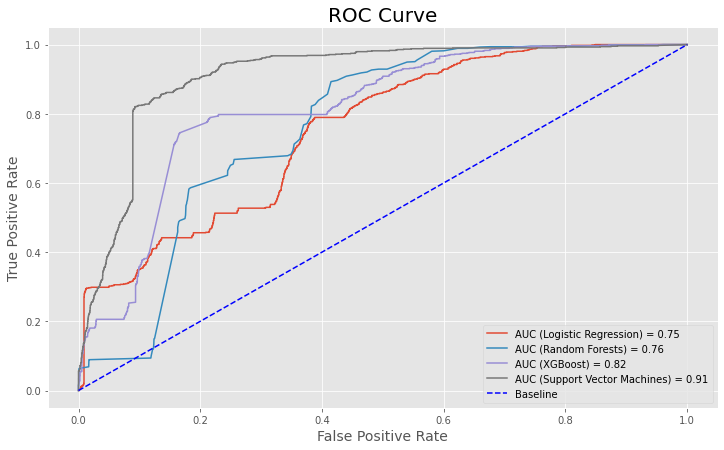

In [22]:
plt.figure(figsize=(12, 7))
plt.plot(fpr_lr, tpr_lr, label=f'AUC (Logistic Regression) = {auc_lr:.2f}')
plt.plot(fpr_rf, tpr_rf, label=f'AUC (Random Forests) = {auc_rf:.2f}')
plt.plot(fpr_xg, tpr_xg, label=f'AUC (XGBoost) = {auc_xg:.2f}')
plt.plot(fpr_svm, tpr_svm, label=f'AUC (Support Vector Machines) = {auc_svm:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('ROC Curve', size=20)
plt.xlabel('False Positive Rate', size=14)
plt.ylabel('True Positive Rate', size=14)
plt.legend();

###  Evaluation Metrics

In [42]:
precision_results = {
    'Model': ['Logistic Regression', 'Random Forest', 'XG Boost', 'Support Vector Machines'],
    '0': [0.94, 0.88, 0.82, 0.99],  
    '1': [0.30, 0.46, 0.44, 0.45]   
}

precision_df = pd.DataFrame(precision_results)
print("Evaluation Metrics - Precision")
precision_df

Evaluation Metrics - Precision


,Model,0,1
0,Logistic Regression,0.94,0.30
1,Random Forest,0.88,0.46
2,XG Boost,0.82,0.44
3,Support Vector Machines,0.99,0.45


In [41]:
recall_results = {
    'Model': ['Logistic Regression', 'Random Forest', 'XG Boost', 'Support Vector Machines'],
    '0': [0.45, 0.82, 0.92, 0.69],  
    '1': [0.90, 0.58, 0.23, 0.96]   
}

recall_df = pd.DataFrame(recall_results)
print("Evaluation Metrics - Recall")
recall_df

Evaluation Metrics - Recall


,Model,0,1
0,Logistic Regression,0.45,0.90
1,Random Forest,0.82,0.58
2,XG Boost,0.92,0.23
3,Support Vector Machines,0.69,0.96


In [44]:
f1_results = {
    'Model': ['Logistic Regression', 'Random Forest', 'XG Boost', 'Support Vector Machines'],
    '0': [0.61, 0.85, 0.87, 0.81],  
    '1': [0.45, 0.52, 0.31, 0.62]   
}

f1_df = pd.DataFrame(f1_results)
print("Evaluation Metrics - F1-Score")
f1_df

Evaluation Metrics - F1-Score


,Model,0,1
0,Logistic Regression,0.61,0.45
1,Random Forest,0.85,0.52
2,XG Boost,0.87,0.31
3,Support Vector Machines,0.81,0.62


In [45]:
auc_results = {
    'Model': ['Logistic Regression', 'Random Forest', 'XG Boost', 'Support Vector Machines'],
    'AUC Score': [0.75, 0.76, 0.82, 0.91]
}

auc_df = pd.DataFrame(auc_results)
print("Evaluation Metrics - AUC")
auc_df

Evaluation Metrics - AUC


,Model,AUC Score
0,Logistic Regression,0.75
1,Random Forest,0.76
2,XG Boost,0.82
3,Support Vector Machines,0.91
